# Training a Restricted Boltzman Machine on MNIST dataset

# Importing needed modules

In [1]:
!pip install idx2numpy
import numpy as np
import gzip
import matplotlib.pyplot as plt
import idx2numpy
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7918 sha256=ced3fdcd4b8fe54732c998083670c926d6c7f52328cc7f5decb6efaaee7fe59c
  Stored in directory: /root/.cache/pip/wheels/34/61/53/a6a64db5e907bdf792f401b5bfb922eabfe6686d08692167f3
Successfully built idx2numpy


# Dowloading the dataset

In [2]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

sources = [
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz',
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz'
]

targets = [
    't10k-images.idx3-ubyte',
    't10k-labels.idx1-ubyte',
    'train-images.idx3-ubyte',
    'train-labels.idx1-ubyte'
]

for src, trg in zip(sources, targets):
  with gzip.open(src, 'rb') as f:
    file_content = f.read()
    with open(trg, "wb") as f_out:
      f_out.write(file_content)

!rm train-images-idx3-ubyte.gz
!rm train-labels-idx1-ubyte.gz
!rm t10k-images-idx3-ubyte.gz
!rm t10k-labels-idx1-ubyte.gz

--2023-03-25 14:30:27--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:130:436c:6f75:6466:6c61:7265
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2023-03-25 14:30:27 (81.0 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-03-25 14:30:27--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:130:436c:6f75:6466:6c61:7265
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 

# Defining some utility functions

In [3]:
def sigmoid(x):
  return 1/(1+np.e**(-x))

sigmoid_vec = np.vectorize(sigmoid)


def visualize_image_grid(images, labels, size=5):
  n = size*size
  fig, ax = plt.subplots(size, size, figsize=(15, 15))

  idx = 0

  for i in range(size):
    for j in range(size):
      ax[i,j].imshow(images[idx], cmap='Greys')
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])
      ax[i,j].set_title(f"Label: {labels[idx]}")

      idx += 1
      


def read_data(train_data_path='train-images.idx3-ubyte',
              train_label_path='train-labels.idx1-ubyte',
              test_data_path='t10k-images.idx3-ubyte',
              test_label_path='t10k-labels.idx1-ubyte'
              ):
  train_data = idx2numpy.convert_from_file(train_data_path)
  train_label = idx2numpy.convert_from_file(train_label_path)
  test_data = idx2numpy.convert_from_file(test_data_path)
  test_label = idx2numpy.convert_from_file(test_label_path)

  return train_data, train_label, test_data, test_label


def get_first_k_images(label, digit, k=3):
  return np.argwhere(label == digit)[:k]


def compute_mse(org, rec):
  org = org.reshape(784)
  rec = rec.reshape(784)
  mse = ((org-rec)**2).sum()
  return mse


def plot_weights(M, n_cols = 5, figsize=(15, 15)):

  v_dim, h_dim = M.shape

  img_size = int(np.sqrt(v_dim))
  n_rows = h_dim // n_cols

  n_rows = n_rows  if h_dim % n_cols == 0 else n_rows + 1


  fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

  idx = 0
  for i in range(n_rows):
    for j in range(n_cols):

      if idx >= h_dim:
        ax[i,j].set_axis_off()
        continue

      ax[i,j].imshow(M[:, idx].reshape(img_size, img_size), cmap='Greys')
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])

      idx+=1

  plt.show()
      


def plot_result(org, rec, hid, label=None):

  mse = compute_mse(org, rec)

  fig, ax = plt.subplots(1, 3, figsize=(12, 6))

  if label != None:
    fig.suptitle(f"Label: {label}\nMSE: {round(mse, 5)}", fontsize=15)

  fig.subplots_adjust(top=1.1)

  ax[0].imshow(org, cmap='Greys')
  ax[1].imshow(rec, cmap='Greys')
  ax[2].imshow(hid, cmap='Greys')

  ax[0].set_title("Original")
  ax[1].set_title("Reconstructed")
  ax[2].set_title("Hidden representation")

  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[1].set_xticks([])
  ax[1].set_yticks([])
  ax[2].set_xticks([])
  ax[2].set_yticks([])

  plt.show()


def plot_images(model, data, label, digit, k=3):
  size = int(np.sqrt(model.n_hidden))
  for idx in get_first_k_images(label, digit, k=5):
      v_a, v_p, h_a, h_p = model.reconstruct(data[idx.item()].reshape(1, -1))
      plot_result(test_data[idx.item()], v_p.reshape(28, 28), h_p.reshape(size, size), label[idx.item()])
      print("\n\n\n")

# Loading the dataset

In [4]:
train_data, train_label, test_data, test_label = read_data()

train_data = train_data/255
test_data = test_data/255

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


# Visualize images

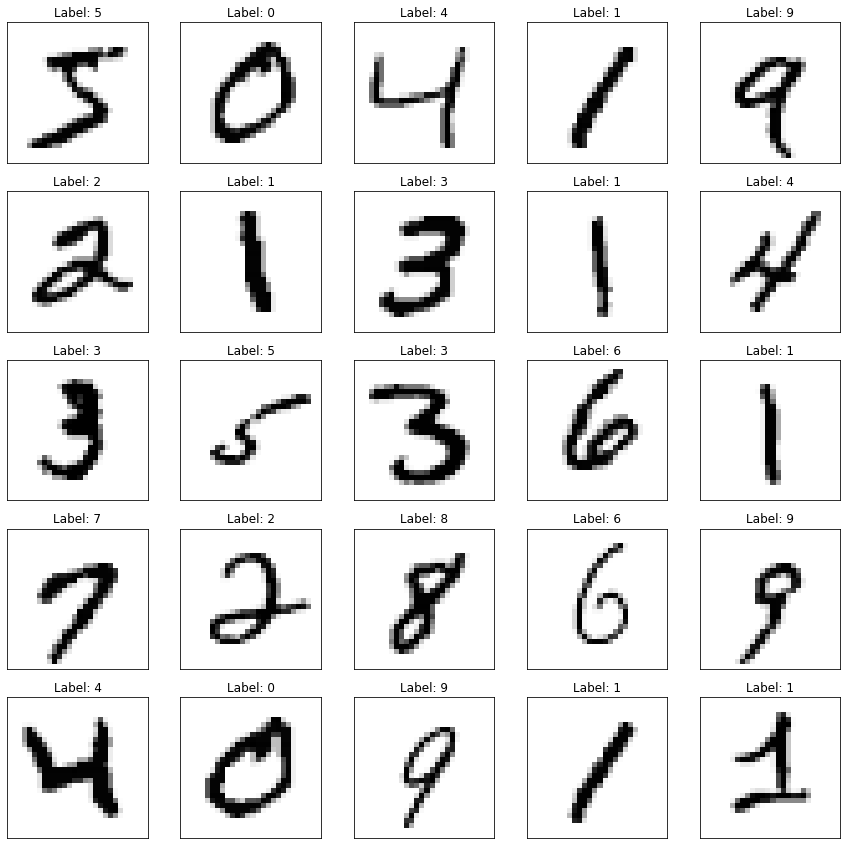

In [5]:
size = 5
visualize_image_grid(train_data[:size*size], train_label[:size*size], 5)

# Defining the class representing the RBM

In [6]:
class RBM:

  def __init__(self, n_visible, n_hidden):
    self.n_hidden = n_hidden
    self.n_visible = n_visible
    self.M = np.random.randn(n_visible, n_hidden)
    self.b = np.random.randn(n_visible)
    self.c = np.random.randn(n_hidden)


  def visible_forward(self, h):
    potential = np.matmul(h, self.M.T) + self.b
    probs = sigmoid(potential)
    mask = np.random.uniform(0, 1, probs.shape)
    activations = (probs > mask).astype(np.uint8)
    return activations, probs


  def hidden_forward(self, v):
    potential = np.matmul(v, self.M) + self.c
    probs = sigmoid(potential)
    mask = np.random.uniform(0, 1, probs.shape)
    activations = (probs > mask).astype(np.uint8)
    return activations, probs


  def reconstruct(self, v):
    h_a, h_p = self.hidden_forward(v)
    v_a, v_p = self.visible_forward(h_a)
    return v_a, v_p, h_a, h_p


  def train(self, train_data, epochs=50, batch_size=32, lr=1):

    n = train_data.shape[0]
    iters = n // batch_size
    iters = iters if (n % batch_size == 0) else iters + 1

    train_data = train_data.reshape(n, -1)

    batch_data = [train_data[i*batch_size:(i+1)*batch_size, :] for i in range(iters)]
    
    for epoch in range(epochs):
      print(f"Training epoch {epoch+1}/{epochs}")

      total_err = 0

      with tqdm(total=iters) as pbar:
        for batch in batch_data:
          
          N = batch.shape[0]

          v_0 = batch
          h_0_a, h_0_p = model.hidden_forward(v_0)
          v_1_a, v_1_p = model.visible_forward(h_0_a)
          h_1_a, h_1_p = model.hidden_forward(v_1_a)
          
          wake = np.einsum('ki,kj->kij', v_0, h_0_a)
          dream = np.einsum('ki,kj->kij', v_1_a, h_1_p)

          err = (((v_1_a-v_0)**2).sum())/N
          total_err += err

          delta_M = ((wake-dream).sum(axis=0))/N
          delta_b = ((v_0-v_1_a).sum(axis=0))/N
          delta_c = ((h_0_p-h_1_p).sum(axis=0))/N

          self.M += delta_M*lr
          self.b += delta_b*lr
          self.c += delta_c*lr

          pbar.update(1)
        
      print(f"\nMSE epoch {epoch+1}: {total_err/iters}")

## Training the model

In [7]:
model = RBM(784, 64)
model.train(train_data, epochs=10, batch_size=32, lr=0.75)

Training epoch 1/10


100%|██████████| 1875/1875 [01:12<00:00, 25.96it/s]



MSE epoch 1: 78.54370143201325
Training epoch 2/10


100%|██████████| 1875/1875 [01:01<00:00, 30.67it/s]



MSE epoch 2: 72.0802418241702
Training epoch 3/10


100%|██████████| 1875/1875 [01:01<00:00, 30.64it/s]



MSE epoch 3: 70.86937182417012
Training epoch 4/10


100%|██████████| 1875/1875 [01:05<00:00, 28.57it/s]



MSE epoch 4: 69.53106613789569
Training epoch 5/10


100%|██████████| 1875/1875 [01:09<00:00, 26.99it/s]



MSE epoch 5: 68.45318025554268
Training epoch 6/10


100%|██████████| 1875/1875 [01:02<00:00, 30.13it/s]



MSE epoch 6: 67.16174646469302
Training epoch 7/10


100%|██████████| 1875/1875 [01:00<00:00, 30.83it/s]



MSE epoch 7: 65.87224267384353
Training epoch 8/10


100%|██████████| 1875/1875 [01:05<00:00, 28.69it/s]



MSE epoch 8: 64.93058090913738
Training epoch 9/10


100%|██████████| 1875/1875 [01:01<00:00, 30.38it/s]



MSE epoch 9: 64.24080672613104
Training epoch 10/10


100%|██████████| 1875/1875 [00:59<00:00, 31.37it/s]


MSE epoch 10: 63.55287450390869


## Evaluate the model

In [8]:
train_size = train_data.shape[0]
test_size = test_data.shape[0]

train_input = train_data.reshape(train_size, 784)
test_input = test_data.reshape(test_size, 784)

train_pred, _, _, _ = model.reconstruct(train_input)
test_pred, _, _, _ = model.reconstruct(test_input)

train_mse = (((train_pred-train_input)**2).sum())/train_size
test_mse = (((test_pred-test_input)**2).sum())/test_size

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Train MSE: 65.04169012482382
Test MSE: 65.13742617608604


## Visualizing the weights of the model

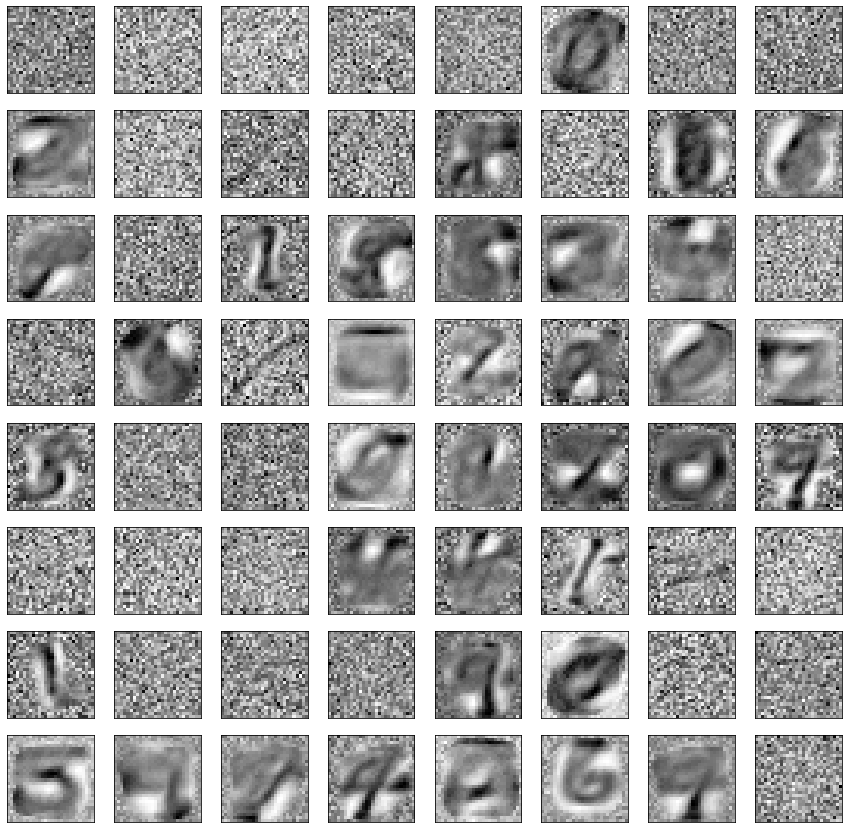

In [9]:
plot_weights(model.M, n_cols=8, figsize=(15, 15))

## Visualize some example for each digit

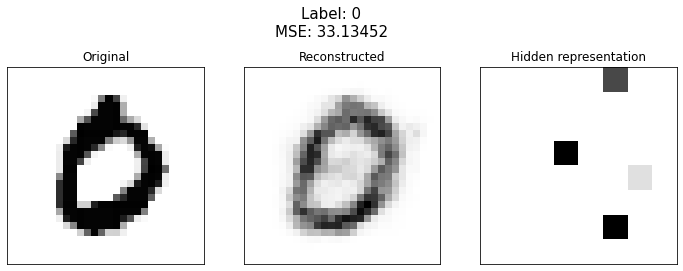

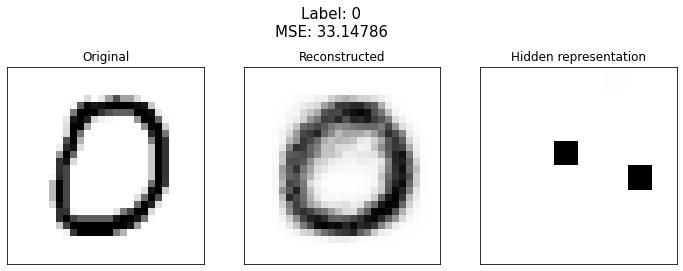

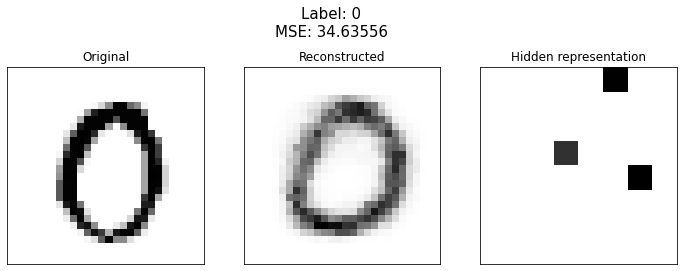

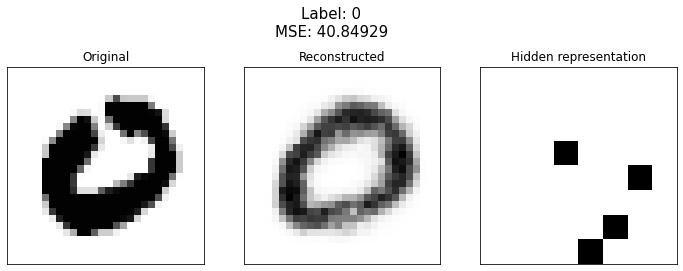

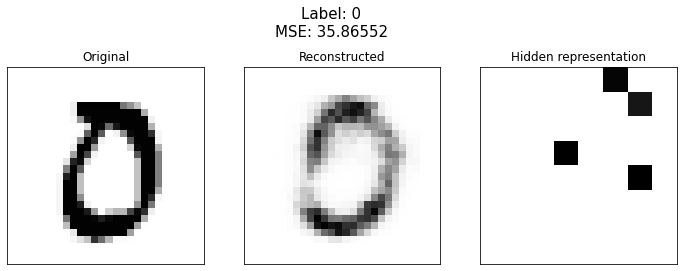

In [10]:
k = 3
plot_images(model, test_data, test_label, 0, k)

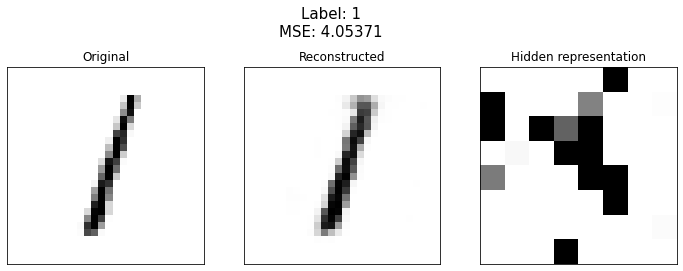

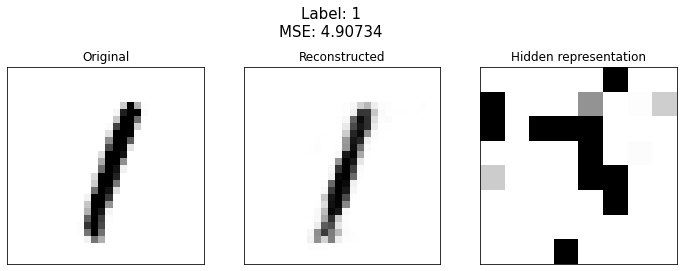

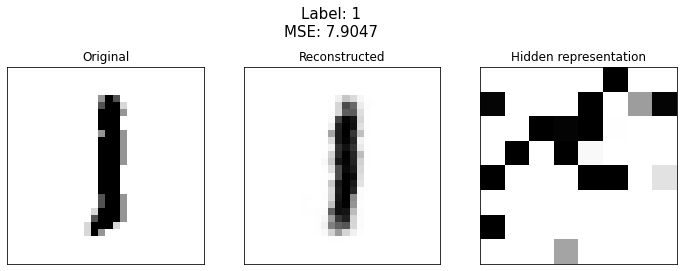

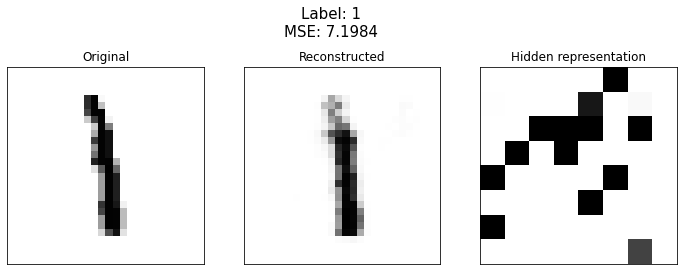

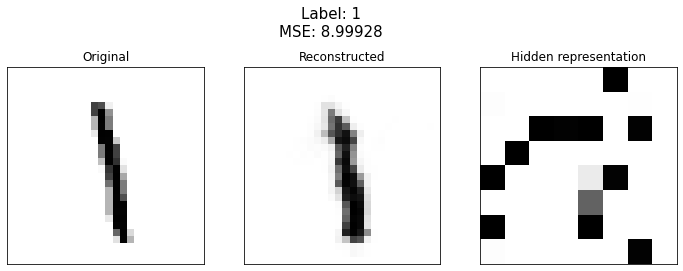

In [11]:
plot_images(model, test_data, test_label, 1, k)

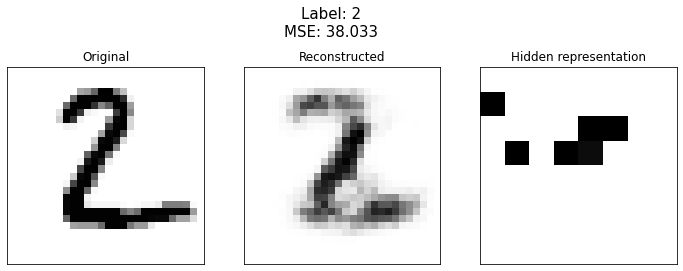

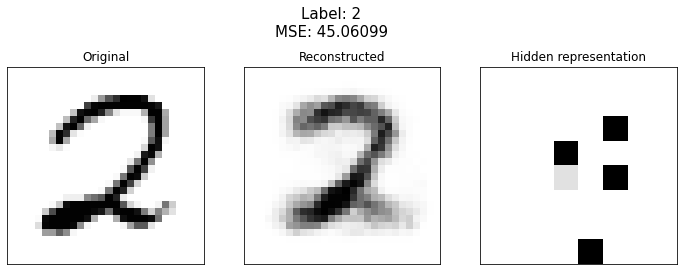

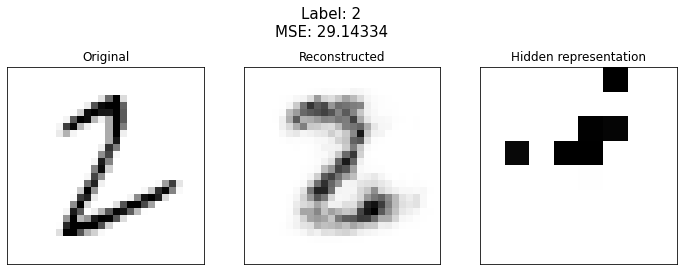

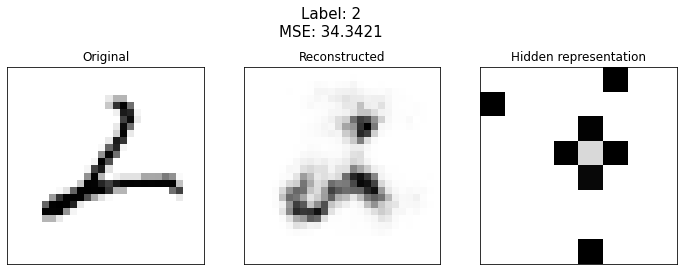

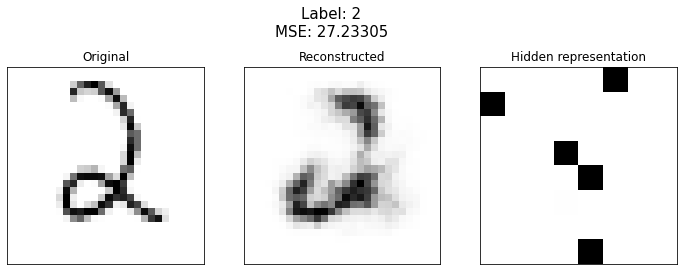

In [12]:
plot_images(model, test_data, test_label, 2, k)

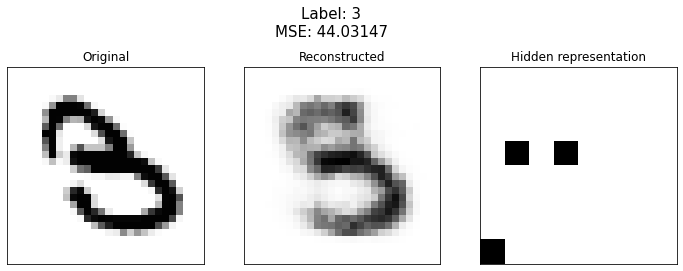

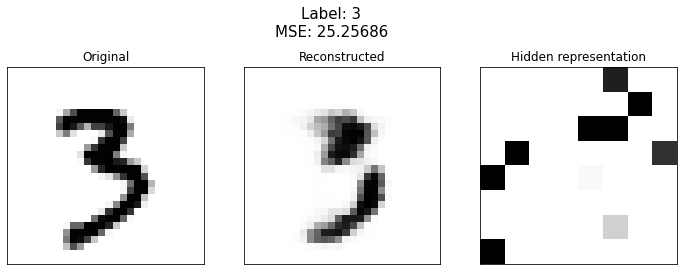

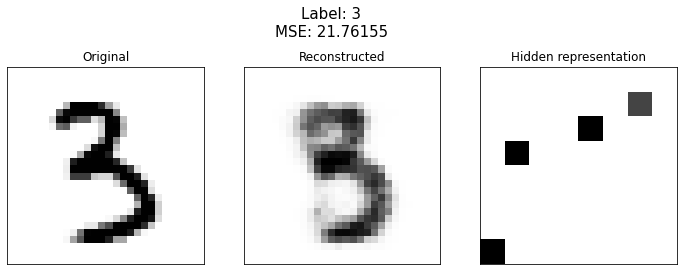

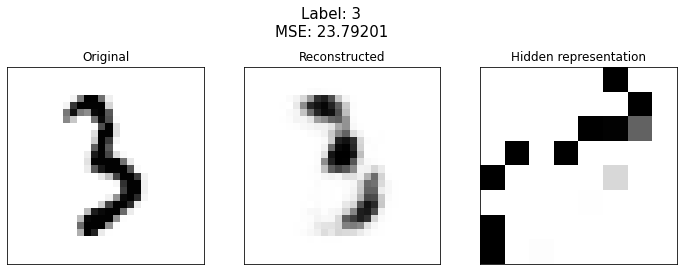

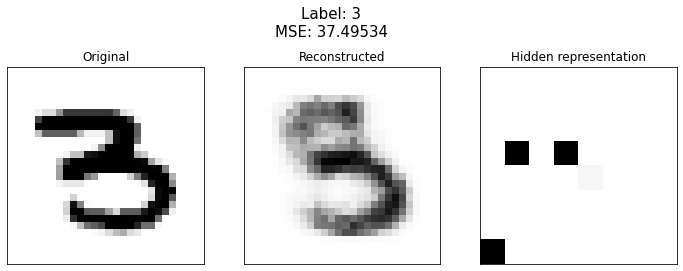

In [13]:
plot_images(model, test_data, test_label, 3, k)

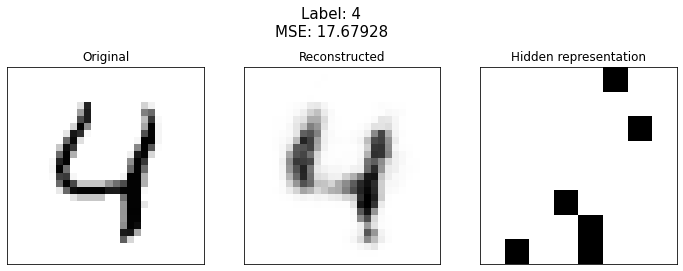

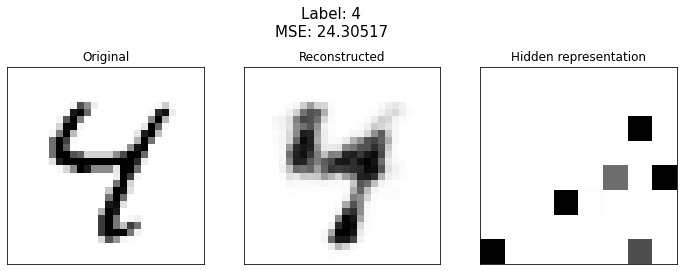

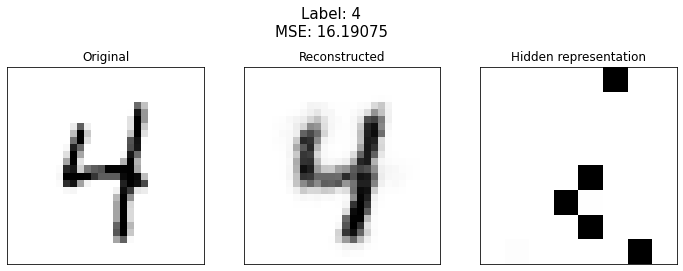

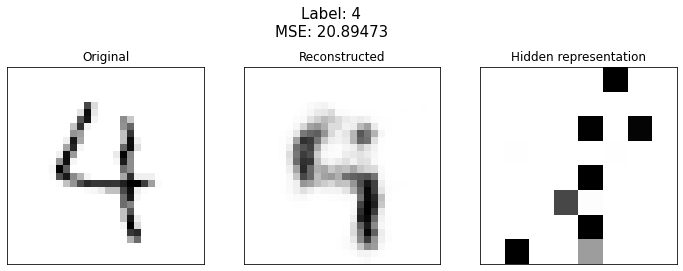

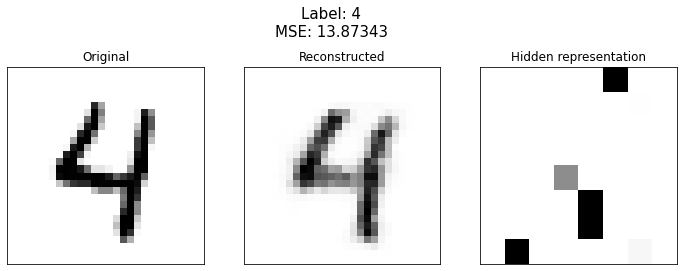

In [14]:
plot_images(model, test_data, test_label, 4, k)

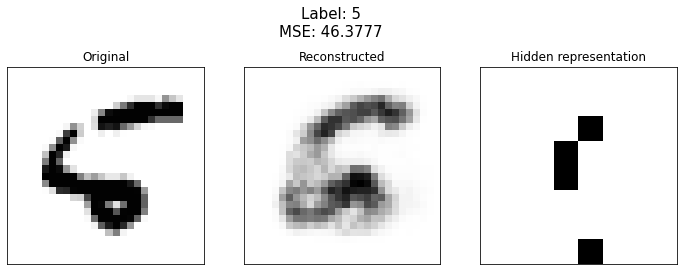

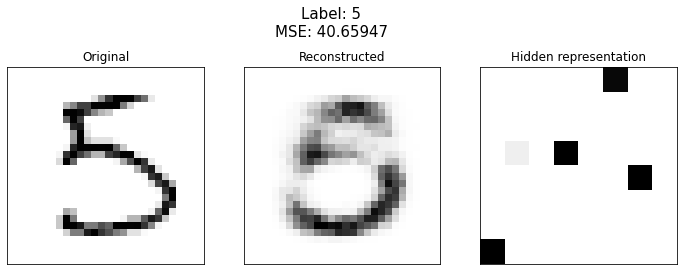

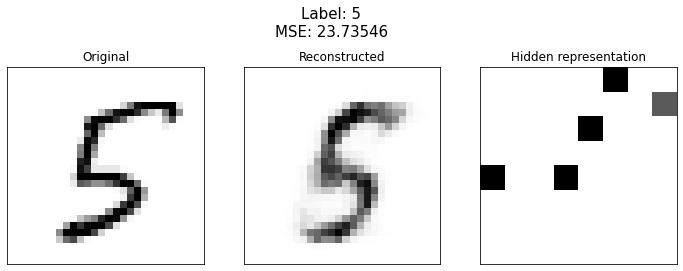

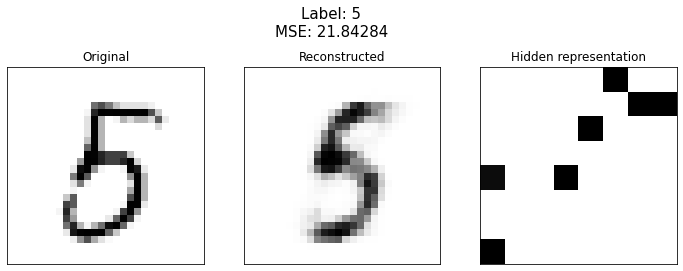

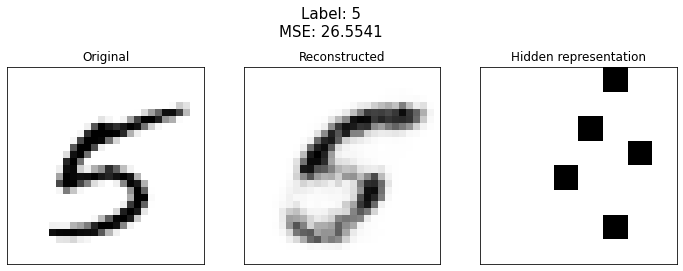

In [15]:
plot_images(model, test_data, test_label, 5, k)

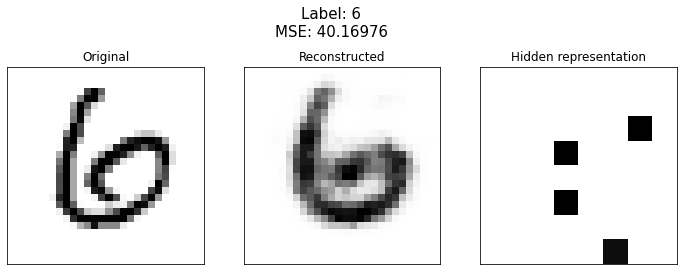

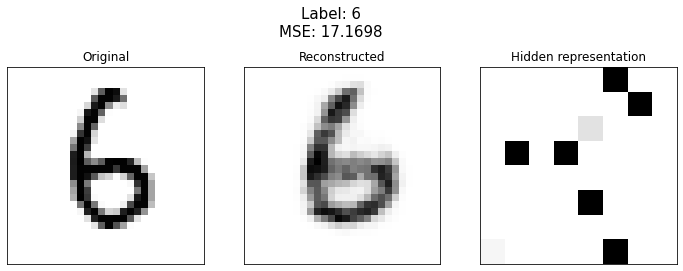

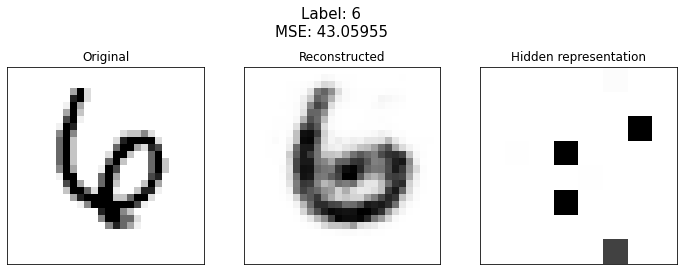

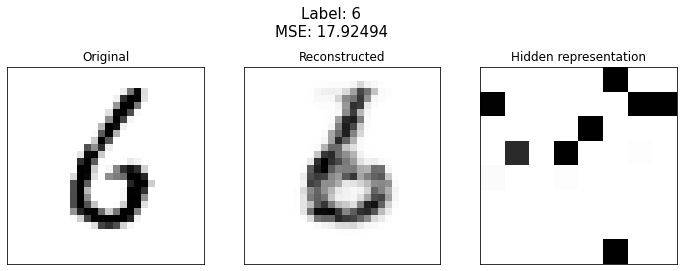

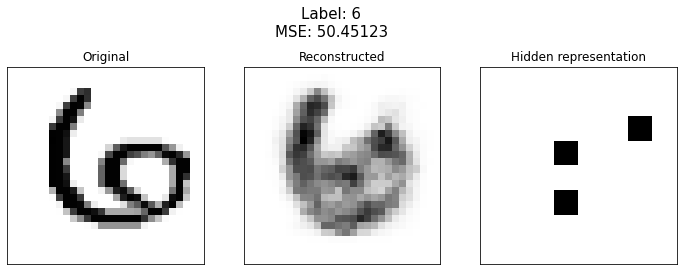

In [16]:
plot_images(model, test_data, test_label, 6, k)

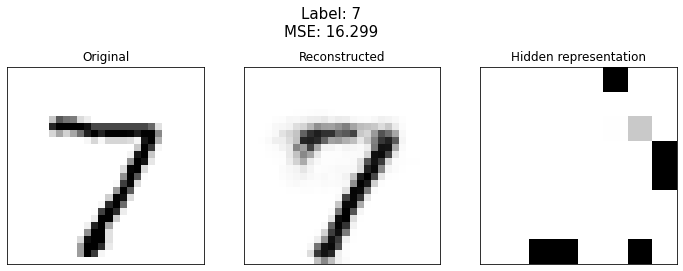

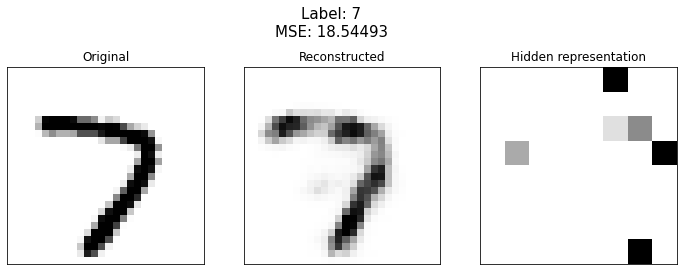

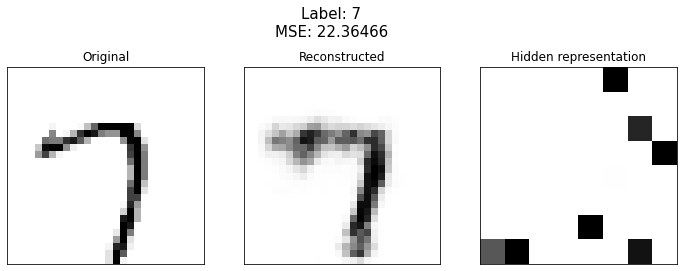

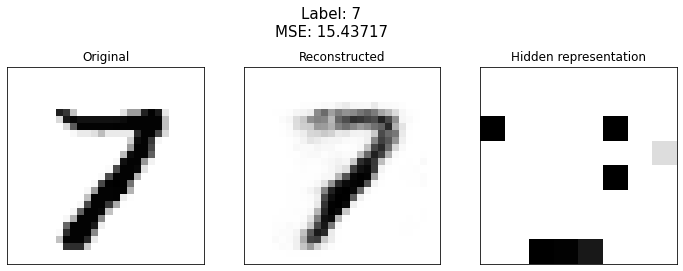

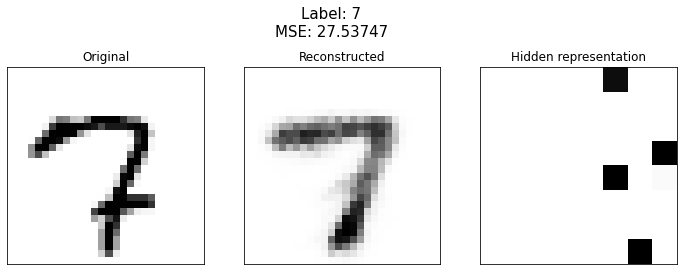

In [17]:
plot_images(model, test_data, test_label, 7, k)

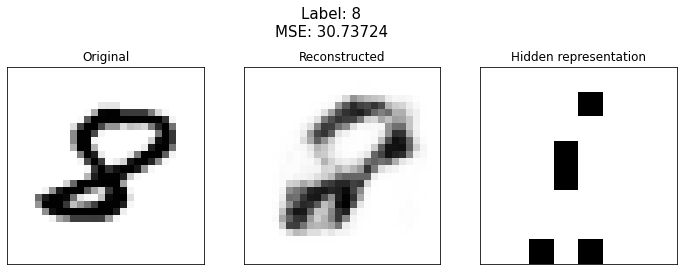

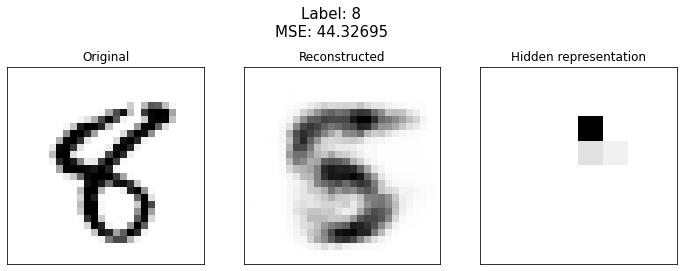

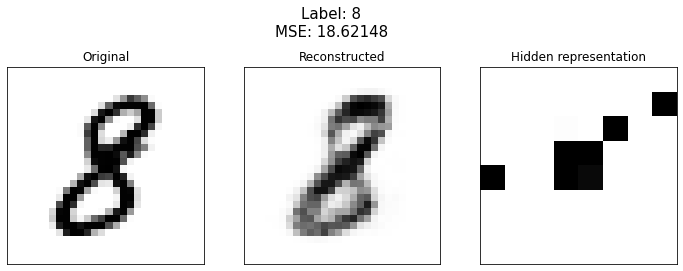

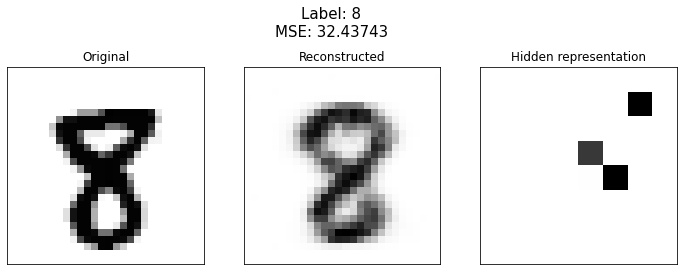

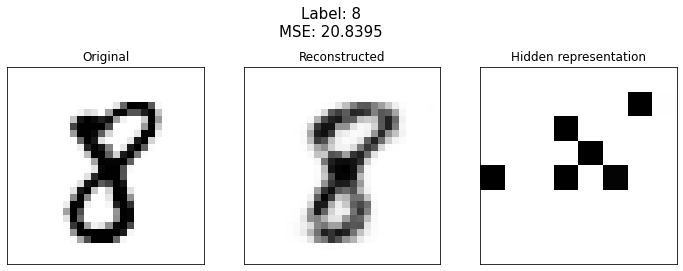

In [18]:
plot_images(model, test_data, test_label, 8, k)

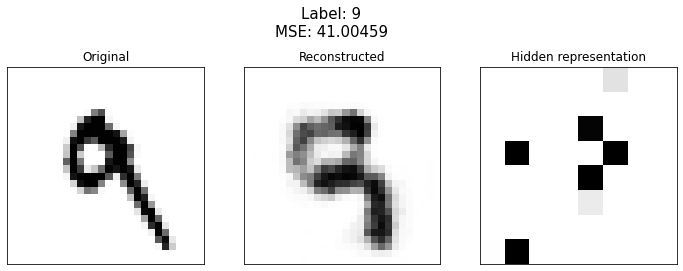

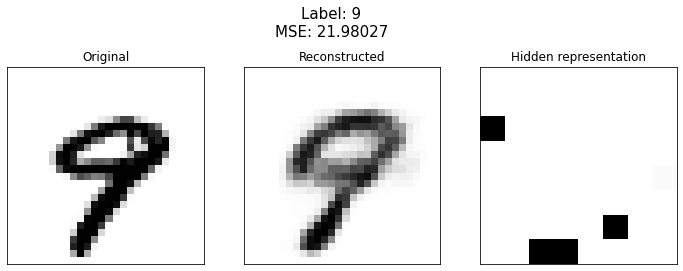

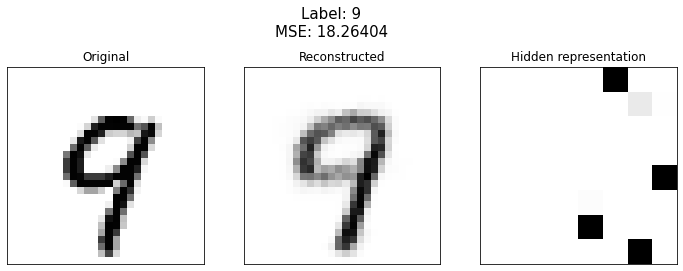

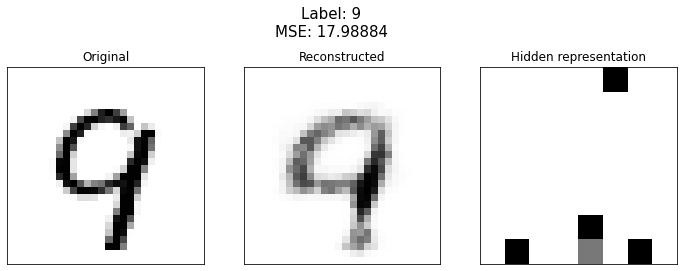

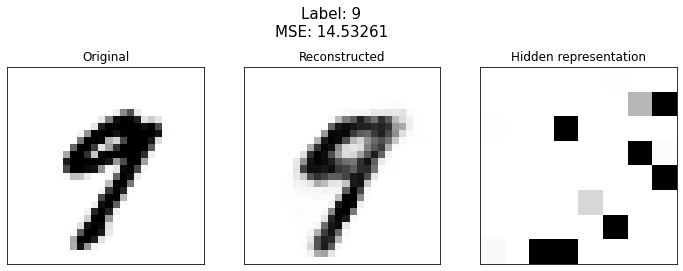

In [19]:
plot_images(model, test_data, test_label, 9, k)